# Final Project for the lecture "Computer Vision and 3D reconstruction"
Winter term 2022 /23

This Notbook contains the full procedure we used to train and evaluate our model. For the purpose of comprehensibility, we migrated the different basic building blocks into different auxilliary files contained in the folder "./utils/". For details about the implementations, please refer to these files.

# 0. Load packages and functions

In [1]:
#packages
import zipfile
import torch.nn as nn
import torch.optim as optim
import torch
from torch.utils.data import DataLoader
import time
import segmentation_models_pytorch as smp
import numpy as np

#Building blocks
from utils.ObjectiveFunctions import *
from utils.CreateTestTrainValSplit import splitter_downsize
from DataSet import ImSegDataSet
import utils.unet_utils as ut
from utils.unet_utils import train
import matplotlib.pyplot as plt

c:\ProgramData\Anaconda3\envs\ml_homework\lib\site-packages\skimage\io\manage_plugins.py:23: UserWarning: Your installed pillow version is < 8.1.2. Several security issues (CVE-2021-27921, CVE-2021-25290, CVE-2021-25291, CVE-2021-25293, and more) have been fixed in pillow 8.1.2 or higher. We recommend to upgrade this library.
  from .collection import imread_collection_wrapper


# 1. Getting started

In order to run our precedure, you have to provide the necessary data set. Please download the data set from the kaggle page into the root folder of this repository:

https://www.kaggle.com/datasets/bulentsiyah/semantic-drone-dataset

for details about the data, please refer to this kaggle page or to

https://www.tugraz.at/index.php?id=22387

wher the data set has been published first.

To extract the data, please run the following cell. In total, this requires roughly 12 GB of storage on your device.

In [2]:

with zipfile.ZipFile("./archive.zip", 'r') as zip_ref:
    zip_ref.extractall("./archive")

KeyboardInterrupt: 

To test and train our model, we need independent test and traiing data. to ensure that we do not mix up the two data set, we split the data obtained from the data set into a test set, a validation set and a traiing set. To speed up the data preprocessing during the training of the model, we save downscaled versions of the images. This may take some time. The three resulting subsets of the traiing set are stored in the directory "./data/"

In [4]:
val_size = 50 #Size of the validation set
test_size = 50 #Size of the test set
scaling_factor = 7 #Factor by which the images are downscaled

splitter_downsize(source_X="./archive/dataset/semantic_drone_dataset/original_images/",source_Y="./archive/dataset/semantic_drone_dataset/label_images_semantic/",val_size=val_size,test_size=test_size,scaling_factor=scaling_factor)

Number of instaces: 400
instance 0:	 training set
instance 1:	 training set
instance 2:	 training set
instance 3:	 training set
instance 4:	 validation set
instance 5:	 training set
instance 6:	 training set
instance 7:	 test set
instance 8:	 training set
instance 9:	 training set
instance 10:	 training set
instance 11:	 training set
instance 12:	 training set
instance 13:	 validation set
instance 14:	 training set
instance 15:	 training set
instance 16:	 test set
instance 17:	 training set
instance 18:	 training set
instance 19:	 test set
instance 20:	 test set
instance 21:	 training set
instance 22:	 training set
instance 23:	 training set
instance 24:	 training set
instance 25:	 training set
instance 26:	 training set
instance 27:	 test set
instance 28:	 training set
instance 29:	 training set
instance 30:	 training set
instance 31:	 validation set
instance 32:	 validation set
instance 33:	 training set
instance 34:	 training set
instance 35:	 training set
instance 36:	 training set

# 2. Training of the UNET

After creating the data set, the UNet can be trained. The hyperparameters for the training are all set in the below config file.

In [2]:
#Set the training parameters here
config = {
    "lr": 0.0003,
    "loss":"combo",
    "batchSize":10,
    "patchSize":256,
    "nEpochs":25,
    "bufferSize":5,
    "bufferUpdateFreq":1,
    "bufferPickSize":3,
    "batchSizeDataLoaderTrain":1,
    "useRotation":False,
    "useMirroring":False,
    "scalingFactor":10,
    "useOriginal":True,
    "classCountThreshold":3,
    "modelParameters":{"in_channels":3, "out_channels":24, "sizes":[64, 128, 256, 512]},
    "modelName":"uNet",
    "optimizer":"Adam",
    "BatchFreqValidate":50,
    "DropLossFreq":25
}

#"sizes":[64, 128, 256, 512]}

In [3]:
#Possible loss functions
loss_dict = {
    "dice": DiceLoss,
    "combo":CriterionCombo,
    "focal": FocalLoss
}

#Possible model architectures
model_dict = {
    "uNet":ut.UNet
}

#Possible optimizers
optimizer_dict = {
    "Adam":optim.Adam,
    "SGD":optim.SGD
}

Initialize the model, the data loaders for validation and training as well as the optimizer used to adapt the model parameters

In [6]:
#Select the device on which the training runs
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

#Select the objective function
crit = loss_dict[config["loss"]]

#Initialize the model
model = model_dict[config["modelName"]](**config["modelParameters"]).to(device)
model.apply(ut.initialize_weights)

#Initialize the objective function
optimizer = optimizer_dict[config["optimizer"]](model.parameters(), lr = config["lr"])

#Data set and data loader for the training set
DS_training = ImSegDataSet(PathToDataSet="./data/train_set/",mode = "train")
DL_training = DataLoader(dataset=DS_training,batch_size=config["batchSizeDataLoaderTrain"],shuffle=True)

#Data set and data loader for the validation set
print("\n")
DS_validation = ImSegDataSet(PathToDataSet="./data/validation_set/",mode = "validation")
DL_validation = DataLoader(dataset=DS_validation,batch_size=5)

#Tag to identify the training run
tag = "training_run_1"
print(f"\nThe tag for this training run is:\n{tag}")

#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	train
	Number of instances:	300
	Image: (C,H,W):		(3,571,857)
#########################################################################################


#########################################################################################
INFO ABOUT THE DATA SET:
	Mode of the data set:	validation
	Number of instances:	50
	Image: (C,H,W):		(3,571,857)
#########################################################################################

The tag for this training run is:
training_run_1


Train the model given the above hyper parameters

In [7]:
'''try:'''
result = train(
    model = model, 
    dataloader_training = DL_training, 
    dataLoader_validation = DL_validation,
    optimizer = optimizer, 
    criterion = crit, 
    device = device, 
    buffer_size = config["bufferSize"], 
    buffer_update_freq = config["bufferUpdateFreq"],
    buffer_pick_size = config["bufferPickSize"],
    n_epochs = config["nEpochs"],
    patch_size = config["patchSize"],
    batch_size = config["batchSize"],
    tag = tag,
    rotation = config["useRotation"],
    mirroring = config["useMirroring"],
    scaling_factor = config["scalingFactor"],
    use_original = config["useOriginal"],
    threshold=config["classCountThreshold"],
    config = config
    )

'''except RuntimeError:
    torch.cuda.empty_cache()'''

Epoch: 1 



 50%|█████     | 1/2 [00:14<00:14, 14.89s/it]

1 1 1
1 2 2
1 3 3


100%|██████████| 2/2 [01:01<00:00, 30.89s/it]


Epoch: 2 



  0%|          | 0/2 [00:00<?, ?it/s]

2 1 4


 50%|█████     | 1/2 [00:55<00:55, 55.74s/it]

2 2 5
2 3 6
2 4 7


100%|██████████| 2/2 [01:58<00:00, 59.10s/it]


'except RuntimeError:\n    torch.cuda.empty_cache()'

Plot the training loss and the performance of the model on the validation set after different epochs.

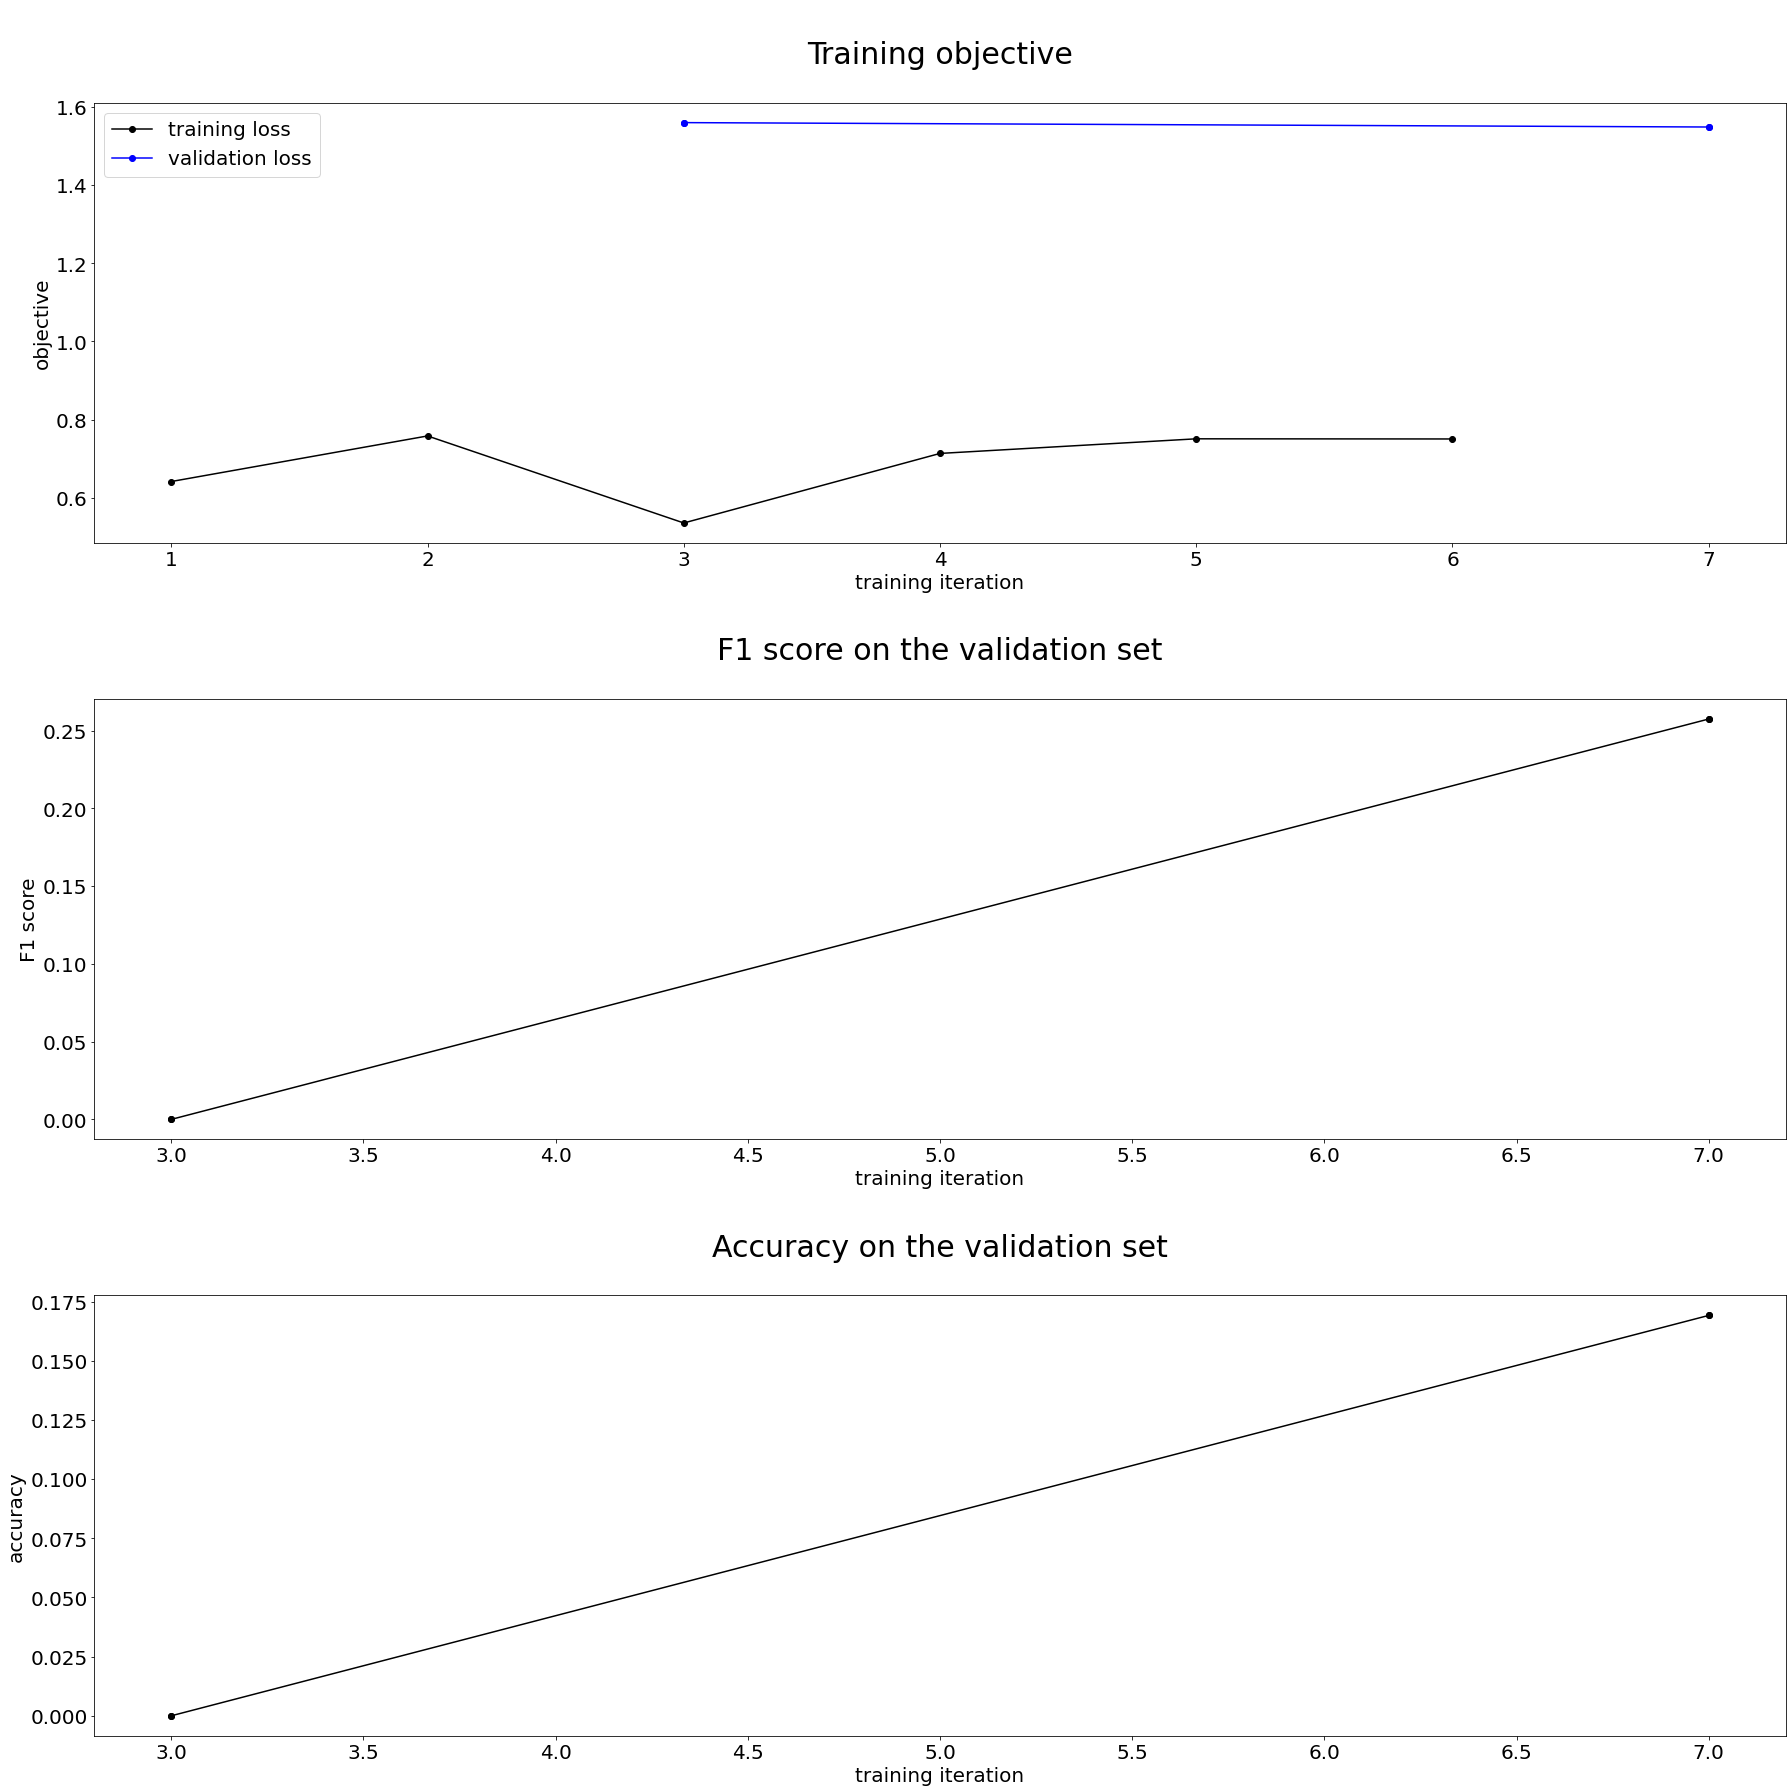

In [42]:
fs_labels = 20
fs_titles = 30
fontdict_labels = {"fontsize":fs_labels}
fs_labels = 20
fontdict_titles = {"fontsize":fs_titles}

fig,axs = plt.subplots(3,1,figsize = (25,25))

#Objective value
axs[0].set_title("\nTraining objective\n",fontdict=fontdict_titles)
axs[0].set_xlabel("training iteration",fontdict=fontdict_labels)
axs[0].set_ylabel("objective",fontdict=fontdict_labels)
axs[0].tick_params(axis='both', which='major', labelsize=fs_labels)

#Load the training loss
trainigLoss = np.loadtxt(f"results/{tag}/data/training_loss.txt",skiprows=1)

#Load the validation loss
validationLoss = np.loadtxt(f"results/{tag}/data/validation_loss.txt",skiprows=2)

axs[0].plot(trainigLoss[:,0],trainigLoss[:,1],color = "k",marker = "o",label = "training loss")
axs[0].plot(validationLoss[:,0],validationLoss[:,3],color = "b",marker = "o",label = "validation loss")
axs[0].legend(fontsize = fs_labels)

#F1 score
axs[1].set_title("\nF1 score on the validation set\n",fontdict=fontdict_titles)
axs[1].set_xlabel("training iteration",fontdict=fontdict_labels)
axs[1].set_ylabel("F1 score",fontdict=fontdict_labels)
axs[1].tick_params(axis='both', which='major', labelsize=fs_labels)

f1validation = np.loadtxt(f"results/{tag}/data/F1_score.txt",skiprows=2)
axs[1].plot(f1validation[:,0],f1validation[:,3],color = "k",marker = "o")

#accuracy
axs[2].set_title("\nAccuracy on the validation set\n",fontdict=fontdict_titles)
axs[2].set_xlabel("training iteration",fontdict=fontdict_labels)
axs[2].set_ylabel("accuracy",fontdict=fontdict_labels)
axs[2].tick_params(axis='both', which='major', labelsize=fs_labels)

f1validation = np.loadtxt(f"results/{tag}/data/accuracy.txt",skiprows=2)
axs[2].plot(f1validation[:,0],f1validation[:,3],color = "k",marker = "o")
plt.tight_layout()

Visualize the distribution of the number of classes per patch during the training

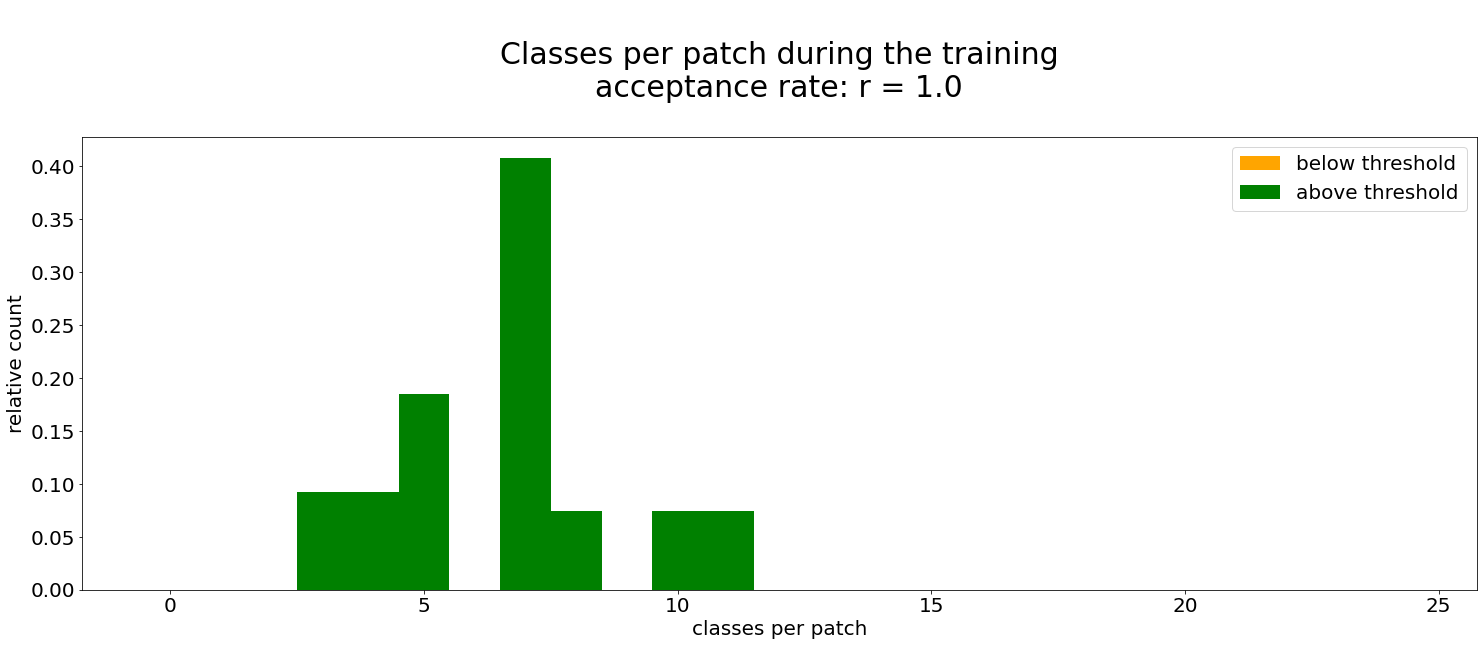

In [40]:
fig = plt.figure(figsize = (25,25 / 3))
ax = plt.axes()

classesPerPatch = np.loadtxt(f"results/{tag}/data/classes_per_patch.txt",skiprows=1)
classesPerPatch /= classesPerPatch.sum()

r = classesPerPatch[config["classCountThreshold"]:].sum() / classesPerPatch.sum()

ax.set_title(f"\nClasses per patch during the training\nacceptance rate: r = {round(r,4)}\n",fontdict=fontdict_titles)
ax.set_xlabel("classes per patch",fontdict=fontdict_labels)
ax.set_ylabel("relative count",fontdict=fontdict_labels)
ax.tick_params(axis='both', which='major', labelsize=fs_labels)
ax.bar(x = np.arange(0,config["classCountThreshold"]),height=classesPerPatch[:config["classCountThreshold"]],width=1,color = "orange",label = "below threshold")
ax.bar(x = np.arange(config["classCountThreshold"],25),height=classesPerPatch[config["classCountThreshold"]:],width=1,color = "g",label = "above threshold")
ax.legend(fontsize = fs_labels)